# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Серов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L2 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \frac{\partial L}{\partial w_i} = \frac{1}{N}\sum_{k}\frac{e^{-y^{(k)}g(x^{(k)})}}{1+e^{-y^{(k)}g(x^{(k)})}}(-y^{(k)}x_i^{(k)}) + \frac{2}{C}w_i = \frac{1}{N}\sum_{k}\frac{-y^{(k)}x_i^{(k)}}{1+e^{y^{(k)}g(x^{(k)})}} + \frac{2}{C}w_i $$

В этой формуле $x^{(i)} = (1,x_1^{(i)},x_2^{(i)},\dots)$. 

## Имплементация (5 баллов)

In [28]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.5, max_epoch=10, batch_size=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_size = batch_size
        
    def error(self, X, y):
        return 1.0 / len(X) * np.sum(np.log(1 + np.exp(-y * np.dot(X, self.W))))
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.errors = list()
        self.W = np.ones(X.shape[1] + 1, dtype='float64')
        X = np.concatenate((np.ones(len(y)).reshape(-1,1), X), axis = 1)
        y = y*2-1 #replace 0 with -1
        for epoch in xrange(1, self.max_epoch):
            dL = np.zeros((len(self.W)), dtype = 'float64')
            random_idxs = np.random.choice(len(y), len(y), replace=False)
            X_shuffled = X[random_idxs]
            y_shuffled = y[random_idxs]
            for i in xrange(0, len(y), self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size,:]
                y_batch = y_shuffled[i:i+self.batch_size]
                G = np.dot(X_batch, self.W)
                dL = - 1.0/self.batch_size * (np.dot(y_batch / (1 + np.exp(y_batch*G)), X_batch))
                dL = dL + 2.0/self.C * self.W
                #print "self.W={}".format(self.W[0])
                #print "dL={}".format(dL[0])
                self.W = self.W - self.alpha * dL / epoch 
            self.errors.append(self.error(X,y))
        
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X = np.concatenate((np.ones(len(X)).reshape(-1,1), X), axis = 1)
        G = np.dot(X, self.W)
        y_hat = G / np.absolute(G) #make 2 classes: -1 and 1
        y_hat = (y_hat+1)/2 #replace -1 with 0
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = np.concatenate((np.ones(len(X)).reshape(-1,1), X), axis = 1)
        G = np.dot(X, self.W)
        y_hat_proba = 1.0 / (1 + np.exp(-G)) 
        #у нас всего 2 класса, так что достаточно возвращать P(y=+1), вероятность другого класса определяется
        #однозначно, как P(y=0)=1-P(y=+1)

        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

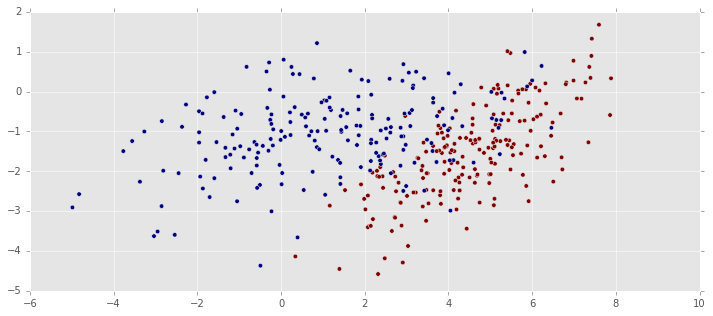

In [6]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [28]:
model = MySGDClassifier(C = 200, alpha = 0.5)
model.fit(X, y)

MySGDClassifier(C=200, alpha=0.5, batch_size=10, max_epoch=10)

In [29]:
point1 = [0, (-model.W[0]/model.W[2])]
point2 = [6, (-model.W[0] - model.W[1]*6)/model.W[2]]

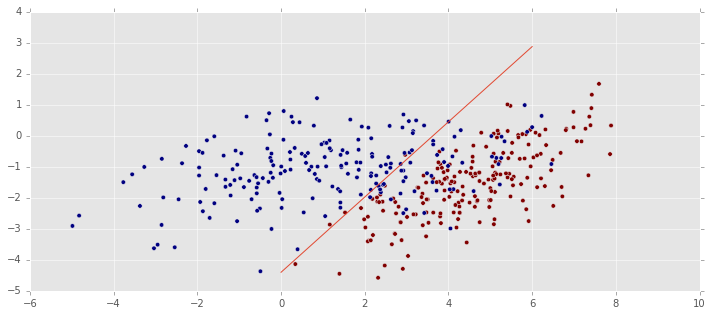

In [30]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.plot([0, 6], [point1[1], point2[1]])

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [73]:
from sklearn.datasets import make_classification

In [74]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

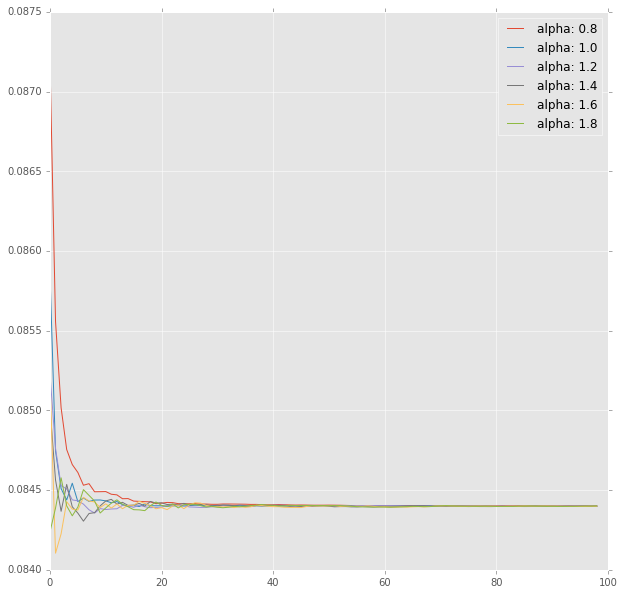

In [80]:
## Your Code Here
plt.figure(figsize=(10,10))
for alpha in xrange(8, 20, 2):
    model = MySGDClassifier(alpha=alpha/10.0, max_epoch=100, C=200, batch_size=1000)
    model.fit(X, y)
    plt.plot (model.errors, label='alpha: ' + str(alpha/10.0))
plt.legend ()

Построим отдельно график для меньших значений альфа.

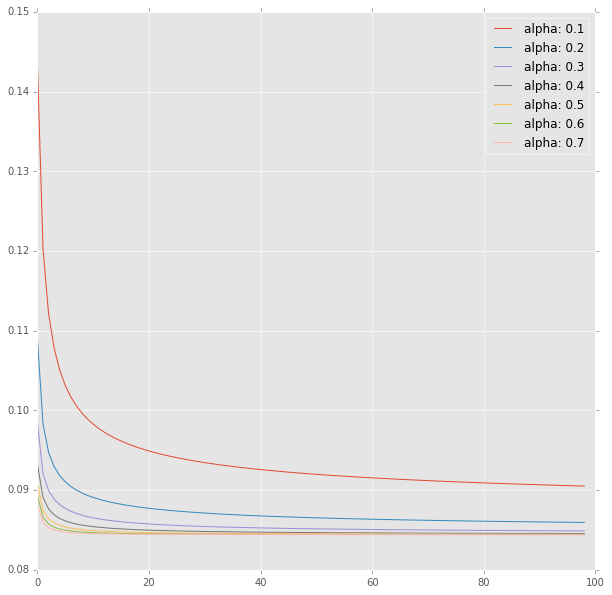

In [81]:
plt.figure(figsize=(10,10))
for alpha in xrange(1, 8):
    model = MySGDClassifier(alpha=alpha/10.0, max_epoch=100, C=200, batch_size=1000)
    model.fit(X, y)
    plt.plot (model.errors, label='alpha: ' + str(alpha/10.0))
plt.legend ()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

При L2 регуляризации на каждом шаге $W = W - \frac{\alpha}{epoch}(dL(\text{без учета регуляризации}) + \frac{2}{C}W)$. 
Если С будет мало, то на начиная с некоторой эпохи $W$ будет менять знак и увеличиваться примерно в $\frac{2}{C}$ раз, т.к. $W_{old}$ и производная функции потерь будут много меньше значения $W$. В итоге алгоритм будет расходиться и произойдет переполнение float.

In [75]:
## Your Code Here
coef = list()
for c in np.logspace(3, -3, 10):
    model = MySGDClassifier(alpha=0.5, max_epoch=100, C=c, batch_size=1000)
    model.fit(X, y)
    coef.append(model.W)
coef = np.array(coef)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in multiply


In [76]:
coef

array([[  1.83048238e+00,  -3.32097846e-03,   1.59792149e-02,
         -2.52035936e-02,  -2.04432772e+00,  -1.00652454e+00,
          1.96095150e+00,   1.69752343e-03,  -1.30112111e+00,
          4.14456169e-03,  -6.11058472e-03],
       [  1.14624432e+00,  -3.90896271e-03,   1.13011770e-02,
         -1.61026019e-02,  -1.58026297e+00,  -7.87744209e-01,
          1.55237291e+00,  -8.01599320e-04,  -8.69160283e-01,
          1.23856841e-03,  -6.61798509e-03],
       [  4.83232562e-01,  -3.27784205e-03,   6.92389357e-03,
         -7.95572530e-03,  -1.06004163e+00,  -5.76619488e-01,
          1.11030559e+00,  -1.08169973e-03,  -4.29380892e-01,
         -4.83073884e-04,  -5.94130563e-03],
       [  1.20759597e-01,  -2.05992148e-03,   3.06412996e-03,
         -2.85801897e-03,  -6.09096450e-01,  -4.11210098e-01,
          6.66024101e-01,   2.34996725e-04,  -1.77364424e-01,
         -8.70544397e-04,  -4.09790015e-03],
       [  1.26573855e-02,  -8.30594623e-04,   8.91290882e-04,
         -8.65

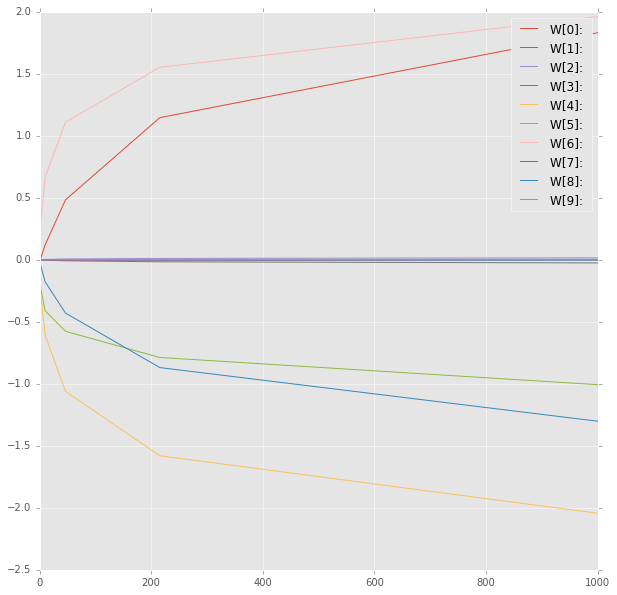

In [59]:
plt.figure(figsize=(10,10))
for i in xrange(len(coef)):
    plt.plot(np.logspace(3, -3, 10), coef[:,i], label='W[{}]: '.format(i))
plt.legend ()

Получается при больших $C$ коэффициенты $W$ большие (слабая регуляриация), при уменьшении $C$ коэффициенты уменьшаются(что логично, т.к. регуляризацией мешаем коэффициентам становиться очень большими). При малых $C$ алгоритм расходится.

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [9]:
df_data=[]

In [2]:
# Загрузка данных целиком
df_list = []
#for chunk in range(1,5):
#    filepath = './lin_model_hw/trainingData_tabular_chunk%d.csv' % chunk
#    df_list.append(pd.read_csv(filepath, sep=','))
#df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './lin_model_hw/trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [6]:
df_data.shape

(500000, 45)

In [6]:
df_data.head()

,gamestate_id,decision,turn,opponent.armor,opponent.attack,opponent.hero_card_id,opponent.hp,opponent.special_skill_used,opponent.weapon_durability,opponent.crystals_all,...,player.played.hp_current,player.played.hp_max,player.hand.nOfMinions,player.hand.nOfSpells,player.hand.nOfWeapons,player.hand.nOfCards,player.hand.nOfPlayable,player.hand.attack,player.hand.crystals_cost,player.hand.hp
0,4687346.0,1,14,0,0,798,5,0,0,10,...,20,23,4,0,1,5,0,20,22,17
1,3270826.0,1,7,0,0,754,22,0,0,6,...,16,17,3,2,2,7,0,17,26,20
2,3189487.0,1,5,3,0,612,29,0,0,4,...,0,0,5,0,0,5,2,26,28,27
3,4098946.0,1,8,0,0,390,26,0,0,7,...,2,2,7,1,1,9,9,36,44,36
4,2661127.0,0,13,0,0,25,30,0,0,10,...,7,7,4,0,0,4,4,13,13,14


In [24]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [28]:
df_data.head().T

gamestate_id,4687346.0,3270826.0,3189487.0,4098946.0,2661127.0
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [26]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50479949999999996

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [48]:
## Youd Code Here
unique_card_opponent = df_data['opponent_hero_card_id'].nunique()
unique_card_player = df_data['player_hero_card_id'].nunique()
print "unique_card_opponent = {}".format(unique_card_opponent)
print "unique_card_player = {}".format(unique_card_player)

unique_card_opponent = 9
unique_card_player = 9


In [3]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

Категориальные переменные - только карта героя у игрока и опонента. Напишем функцию, которая сразу будет готовить датасет.

In [23]:
def prepare_dataset(df_data):
    df_data.columns = df_data.columns.str.replace('.', '_')
    #df_data = df_data.set_index('gamestate_id')
    y_prep = df_data['decision']
    X = df_data.drop(['decision'], axis = 1)
    X_enc = X.loc[:, ['opponent_hero_card_id', 'player_hero_card_id']].values
    encoder.fit(X_enc)
    X_cod = encoder.transform(X_enc).toarray()
    X = X.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis = 1)
    X_prep = np.concatenate((X.values, X_cod), axis = 1)
    return X_prep, y_prep

In [24]:
X_train, y_train = prepare_dataset(df_data)

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [27]:
## Youd Code Here
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
my_model = MySGDClassifier(alpha=0.5, batch_size=10, C=100)
model_log_reg = Pipeline([('scaler', scaler),('model', my_model)])

In [31]:
model_log_reg.set_params(model__alpha=0.7, model__batch_size=1000, model__C=200).fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', MySGDClassifier(C=200, alpha=0.7, batch_size=1000, max_epoch=10))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [54]:
## Youd Code Here
df_data_test = []
df_list = []
for chunk in range(5,8):
    filepath = './lin_model_hw/testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_data_test = pd.concat(df_list)

X_test, y_test = prepare_dataset(df_data_test)

In [66]:
df_data_y_test = pd.read_csv('lin_model_hw/deprecated_testLabels.txt', header=None)
y_test = df_data_y_test.values

In [67]:
X_test.shape

(1250000, 60)

In [68]:
y_test.shape

(1250000, 1)

In [69]:
y_hat = model_log_reg.predict(X_test)

In [70]:
from sklearn.metrics import roc_auc_score

In [71]:
score = roc_auc_score(y_test, y_hat)

In [72]:
score

0.70839166227645567